In [1]:
using JLD
using JuMP  
using Ipopt
using Plots
using LaTeXStrings
using LinearAlgebra
using Plots.PlotMeasures

\begin{equation}
    \left\lbrace \begin{array}{lllll}
    &\displaystyle\max_{u(\cdot)\in [0, u_{\max}]} \ \ J(u):=\int_0^T P\big(x(t),u(t)\big) \; d t  
    \\
    \\
    \text{s.t.}&\\
    &\dot{x}(t) = \big(M(s(t))-u(t)I_n+\varepsilon Z\big)x(t), \\
    \\
       & \dot{s}(t) = - \displaystyle\sum_{j=1}^n\frac{ \mu_j(s(t))x_j(t)}{Y_j}+ u(t)(s_{in}-s(t)),\\
    \\
      &S(x(T))  \leq \alpha,
    \end{array}
    \right.
\end{equation}

**Parameters:**

In [2]:
n = 5 

a = [i for i in 1:n] 
b = [i^2 for i in 1:n]  
Y = ones(n)
s_in = 35.0
x0_def = ones(n)

d = [-1; [-2 for i in 1:(n-2)]; -1]
d1 = [1 for i in 1:(n-1)]
matrix_Z = SymTridiagonal(d, d1);

In [3]:
# import functions of the model
include("functions.jl");

In [4]:
mutable struct incognitas
    t; x; s ; y ; u 
end

**Optimization code:**

In [5]:
function CHEMOSTAT(ε= 0.1, tf = 30.0, umin=0.0, umax = 5.0, α = 0.2, x0 = x0_def, s0 = 1, y0=0, γ=0.1, nsteps=150, tol=1e-8, max_iter=600, display=true)

    # Create JuMP model, using Ipopt as the solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => display ? 5 : 1))
    set_optimizer_attribute(sys, "linear_solver", "mumps")  
    set_optimizer_attribute(sys,"tol", tol)
    set_optimizer_attribute(sys,"acceptable_tol", tol)
    set_optimizer_attribute(sys,"max_iter",max_iter)
    if !display
        set_silent(sys)
    end

    # Include external functions from "functions.jl" file
    register(sys, :μ, 2, μ, autodiff=true)
    register(sys, :M, 4, M, autodiff=true)
    register(sys, :dS, 3, dS, autodiff=true)
    register(sys, :S, 1, S, autodiff=true)
    register(sys, :P, 2, P, autodiff=true)
    
    

    # Constants
    N  = nsteps     # Grid size
    @variables(sys, begin
                 x[1:n,1:N+1] ≥ 1e-6
                 s[1:N+1] ≥ 0
                 y[1:N+1] # cost
          umin ≤  u[1:N+1] ≤ umax
    end)
    T  = tf
    Δt = T/(N)
    
    # Boundary constraints
    @constraints(sys, begin
        con_x0,   x[:,1] == x0
        con_s0,   s[1]   == s0 
        con_y0,   y[1]   == y0 
    end)

    # Dynamics
    @expression(sys, dx[i = 1:n, j = 1:N+1], ((μ(s[j],i) - u[j]) * x[i,j]) +M(ε,x[:,j],s[j],i) ) #dynamic on x
    @expression(sys, ds[j = 1:N+1], dS(x[:,j],s[j],u[j]) ) #dynamics on s
    @expression(sys, du2[j = 2:N-1], (u[j+1] - u[j])^2 ) #smoothing term on u
    @expression(sys, dy[j = 1:N+1], -P(u[j],x[:,j]) ) #cost function 
    @expression(sys, ST, S(x[:,N+1]) ) #constraint value

    # Dynamics with 2nd order Runge-kutta scheme
    @NLconstraints(sys, begin
        con_dx[i=1:n,j=1:N], x[i,j+1] == x[i,j] +  0.5 * Δt *(dx[i,j+1] + dx[i,j])
        con_ds[j=1:N],         s[j+1] == s[j]  + 0.5 * Δt * (ds[j+1]  +  ds[j])
        con_dy[j=1:N],         y[j+1] == y[j]  + 0.5 * Δt * (dy[j+1]  +  dy[j])
    end)       
    
    # Define the inequality constraints
    @NLconstraint(sys, con_ST, ST <= α )
   
    # Objective
    @NLobjective(sys, Min, y[N+1]+  γ*sum(du2[j] for j in 2:N-1))


    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys);
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values 
    x  = value.(x)[:,:]
    s  = value.(s)[:]
    y  = value.(y)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)
           
    return incognitas(t, x, s , y, u), termination_status(sys);
    
end;

**Example of solution:**

In [11]:
# Resolution 

ε    = 0.01
tf   = 75.0
umin = 1e-4 
umax = 3 
α    = 0.4
γ    = 0.4


x0     = 5*ones(n)
s0     = s_in-sum(x0)
y0     = 0
nsteps = 200   
tol    = 1e-5 
max_iter = 20000
display  = false

sol, status = CHEMOSTAT(ε, tf, umin, umax, α, x0, s0, y0, γ,  nsteps, tol, max_iter, display);
println(status)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

LOCALLY_SOLVED


**Plotting of the solution:**

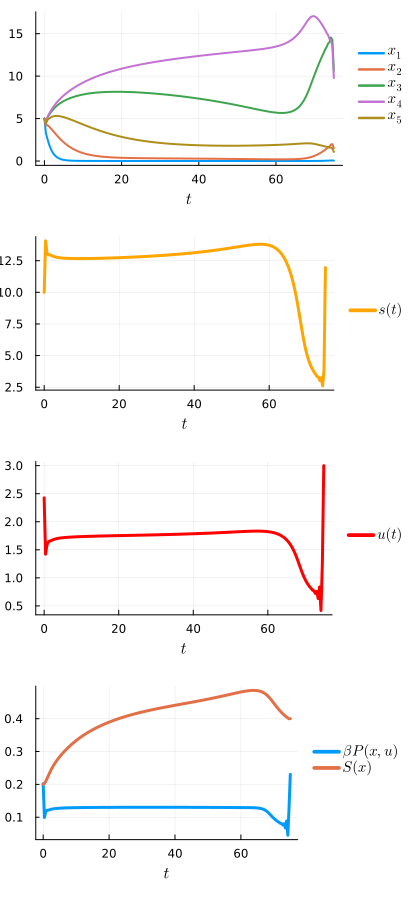

In [12]:
t, s, u  = sol.t, sol.s, sol.u
x = transpose(sol.x)
OF_list = Array{Float64}(undef, length(t), 2) # objective function values

β = 0.25/tf # scaling constant

for i in 1:length(t)
    x_t = x[i, :] 
    s_t = s[i]
    u_t = u[i]
    OF_list[i,:] = [P(u_t,x_t)*β,S(x_t)]
end
label = hcat(reshape([L"x_%$i" for i in 1:n],(1,:)),[L"s"])
p1 = plot(t, hcat(x,s), label=label, lw=2 , fg_legend = :false)
# p2 = plot(t, s, label=L"s(t)", lw=3, linecolor="orange") 
p3 = plot(t, u, label=L"u(t)", lw=3, linecolor="red", left_margin = 3mm)
p4 = plot(t, OF_list, label=[L"\beta P(x,u)\ " L"S(x)"], lw=3)

# p = plot(p1, p2, p3, p4, layout=(4,1), size=(420, 900),legendfont = font(10),
#         xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)
p = plot(p1, p2, p4, layout=(3,1), size=(420, 675),legendfont = font(10),
        xlabel=L"t",grid=true, legend=:outerright, fg_legend = :false)

In [ ]:
savefig(p, "output/OCPc=0.pdf")

In [13]:
# Computation of the objetive function value
suma = 0
for k in 1:(length(t)-1)
    suma += (t[k+1]-t[k])*300*(OF_list[k,1]+OF_list[k+1,1])/2
end
println("J=",suma)

J=2834.3698565028362


**Computation for multiple thresholds $c$**

_This cell may take around 20 min to run_

In [6]:
ε   = 0.01
tf  = 75.0
umin = 1e-4
umax = 3

len = 15

α_min = 0.3
α_max = 0.48
α_list = vcat(range(α_min, α_max, len), range(0.481,1.0,5)) # take α in a concatenated list to reduce execution time


OF_list = Array{Float64}(undef, len+5, 3) # array to save [J(u),S(x(T)),α]

x0     = 5*ones(n)
s0     = s_in-sum(x0)
y0     = 0 # objective function
nsteps = 200   
tol    = 1e-5 
max_iter = 30000
display  = false

for i in 1:len+5
    α = α_list[i]
    γ = 0.4
    try
        sol, status = CHEMOSTAT(ε, tf, umin, umax, α, x0, s0, y0, γ,  nsteps, tol, max_iter, display);
        if status==MOI.OPTIMAL || status==MOI.LOCALLY_SOLVED
            t, x, u  = sol.t, sol.x, sol.u
            J = 0
            for k in 1:(length(t)-1)
                J += (t[k+1]-t[k])*(P(u[k],x[:,k])+P(u[k+1],x[:,k+1]))/2
            end
            OF_list[i,:] = [J, S(x[:,length(t)]), α]
        else
            println(status)
            OF_list[i,:] = [NaN, NaN, α]
        end
    catch e
        println("α=",α," error:",e)
    end
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

ITERATION_LIMIT
ITERATION_LIMIT


In [8]:
# save the result to compare with the static solution
save("sol_dyn.jld", "OF_list", OF_list);

In [7]:
OF_list

20×3 Matrix{Float64}:
 2520.02    0.3       0.3
  NaN     NaN         0.312857
  NaN     NaN         0.325714
 2655.8     0.338571  0.338571
 2695.66    0.351429  0.351429
 2733.49    0.364286  0.364286
 2770.12    0.377143  0.377143
 2806.25    0.39      0.39
 2842.45    0.402857  0.402857
 2879.46    0.415714  0.415714
 2918.13    0.428571  0.428571
 2932.74    0.437214  0.441429
 2932.74    0.437213  0.454286
 2932.74    0.437208  0.467143
 2932.74    0.437215  0.48
 2932.74    0.437218  0.481
 2932.74    0.437211  0.61075
 2932.74    0.437206  0.7405
 2932.74    0.437215  0.87025
 2932.74    0.437204  1.0

In [9]:
0.25/75

0.0033333333333333335